# **Code for Q4**

## **a) Random forest implementation from scratch**

In [1]:
import csv
import numpy as np
from math import *
from random import sample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
def entropy(p):
    return -(p*log2(p))-((1-p)*log2(1-p))

def gini(p):
    return 1-(p*p)-((1-p)*(1-p))

def counter(dataset,length,fea):
    class0=0
    class1=0
    for i in range(length):
        if(int(dataset[i][fea])==0):
            class0+=1
        else:
            class1+=1
            
    return class0,class1   

def splitter(dataset,attribute,threshold, length):
    r_data=[]
    l_data=[]
    for i in range(length):
        if(dataset[i][attribute]>=threshold):
            r_data.append(dataset[i])
        else:
            l_data.append(dataset[i])
            
    r_data=np.array(r_data)
    l_data=np.array(l_data)
    return l_data,r_data      

In [3]:
class DecisionTree():
    
    # implementing tree as a dictionary
    tree={}
    
    def learn(self,training_set,no_of_th,imp_func,feas_allowed_for_use):        
        tree={'attribute':None,'threshold':None,'left_subtree':None,'right_subtree':None,'prediction':None}
        
        # randomizing
        training_set=np.array(training_set,dtype=float)
        np.random.shuffle(training_set)
        
        # assuming training_set has labels included
        no_of_data=training_set.shape[0]
        no_of_feas=training_set.shape[1]-1
        
        # it is a binary classification problem
        class0,class1=counter(training_set,no_of_data,no_of_feas)
        p0=(class0)/(class0+class1)        

        # if the purity is 1, then we have reached a leaf node
        if(p0==0):
            tree['prediction']=1
            return tree        
        elif(p0==1):
            tree['prediction']=0
            return tree  
        
        imp_p=imp_func(p0)
        
        # finding Minimum and Maximum values of each attribute which ocurred in the training data
        Min_val=np.min(training_set[:,:-1],0)
        Max_val=np.max(training_set[:,:-1],0)

        # storing thresholds
        th=[]
        temp_list=[]
        for i in range(no_of_feas):
            a=Min_val[i]
            b=Max_val[i]
            th.append(np.linspace(a,b,no_of_th+1,endpoint=False))
            temp_list.append(i)
        th=np.array(th)
        th=th[:,1:]
        th=np.array(th)

        # randomly choosing some features
        chosen_feas=sample(temp_list,feas_allowed_for_use)

        # finding best split
        max_ig=-100        
        for i in range(feas_allowed_for_use):               
            for j in th[chosen_feas[i]]:
                
                left_data,right_data=splitter(training_set,chosen_feas[i],j,no_of_data)                
                no_of_ldata=left_data.shape[0]
                no_of_rdata=right_data.shape[0]                
                
                # case of no split
                if(no_of_ldata==no_of_data or no_of_ldata==0):
                    continue
                                     
                l_class0,l_class1=counter(left_data,no_of_ldata,no_of_feas)  
                l_p0=(l_class0)/(no_of_ldata)

                if(l_p0==0 or l_p0==1):
                    l_imp = 0
                else:
                    l_imp = imp_func(l_p0)

                r_class0,r_class1=counter(right_data,no_of_rdata,no_of_feas)                                        
                r_p0=(r_class0)/(no_of_rdata)

                if(r_p0==0 or r_p0==1):
                    r_imp = 0
                else:
                    r_imp = imp_func(r_p0)                        

                imp_c=(r_imp*no_of_rdata)+(l_imp*no_of_ldata)
                imp_c/=no_of_data
                ig=imp_p-imp_c
                # print('ig',ig,'max_ig',max_ig)

                if(ig>max_ig):
                    max_ig=ig
                    tree['attribute']=chosen_feas[i]
                    tree['threshold']=j
                    # print('Maxig,att,th',max_ig,attribute,threshold)
                        
        attribute=tree['attribute']
        threshold=tree['threshold']

        if(tree['attribute']==None and tree['threshold']==None):
            if(class1>=class0):
                tree['prediction']=1
            else:
                tree['prediction']=0
            return tree

        final_left_data,final_right_data=splitter(training_set,attribute,threshold,no_of_data) 
        
        left_subtree = DecisionTree.learn(self,final_left_data,no_of_th,imp_func,feas_allowed_for_use)
        right_subtree = DecisionTree.learn(self,final_right_data,no_of_th,imp_func,feas_allowed_for_use)
        
        tree['left_subtree']=left_subtree
        tree['right_subtree']=right_subtree        
        
        self.tree = tree
        return tree
                
    def classify(self,tree,test_instance):

        if(tree['prediction']!=None):
            result = tree['prediction']
            return result
        else:
            if(test_instance[tree['attribute']]>=tree['threshold']):
                return DecisionTree.classify(self,tree['right_subtree'],test_instance)
            else:
                return DecisionTree.classify(self,tree['left_subtree'],test_instance)        
        

In [4]:
# Loading dataset
with open("dataset.txt") as f:
    data = [list(line) for line in csv.reader(f, delimiter=" ")]

# typecasting data for easier calculations
data = np.array(data,dtype=float)
np.random.shuffle(data)
total_data=data.shape[0]
total_feas=data.shape[1]

# splitting training and test data
train=data[:int(ceil(0.7*total_data))][:]
test=data[int(ceil(0.7*total_data)):][:]
train=np.array(train,dtype=float)
test=np.array(test,dtype=float)
np.random.shuffle(test)

root_fs=int(sqrt(total_feas))

In [5]:
def random_forest(no_of_trees,m,train_data,test_data,oob): 

    total_train=train_data.shape[0]
    total_test=test_data.shape[0]    

    copy_train=train_data.copy() 

    if(oob==0):
        RESULTS=[]
        for i in range(no_of_trees):
            np.random.shuffle(copy_train)
            np.random.shuffle(copy_train)
            Tree = DecisionTree()
            
            # using only 1/10th data and sqrt(total_feas) features
            tree=Tree.learn(copy_train[:int(ceil(0.1*total_train)),:],15,entropy,m)        
            
            # Classify the test set using the tree we just constructed
            results = []
            for instance in test_data:
                result = Tree.classify(tree,instance)
                results.append(result)
            RESULTS.append(results)

        # majority vote and accuracy
        Acc=0
        answers=(np.sum(RESULTS,0))/100
        for i in range(total_test):
            if(int(test_data[i][-1])==0 and answers[i]<0.5):
                Acc+=1
            elif(int(test_data[i][-1])==1 and answers[i]>=0.5):
                Acc+=1    

        Acc=(Acc/total_test)
        print("Accuracy: %.4f" % Acc)
        
        return Acc

    elif(oob!=0):

        OOB_matrix=[]
        indexing=[]
        for i in range(total_train):
            OOB_matrix.append([])
            indexing.append(i)

        indexing=(np.array(indexing)).reshape(total_train,1)
        index_train=np.concatenate((copy_train,indexing),axis=1)

        for i in range(no_of_trees):
            np.random.shuffle(index_train)
            np.random.shuffle(index_train)
            Tree = DecisionTree()
            
            # using only 1/10th data and sqrt(total_feas) features
            tree=Tree.learn(index_train[:int(ceil(0.1*total_train)),:-1],15,entropy,m)

            oob_data=index_train[int(ceil(0.1*total_train)):]
            for instance in oob_data:
                OOB_matrix[int(instance[-1])].append(Tree.classify(tree,instance[:-1]))

        OOB_pred=np.zeros(total_train)
        oob_err=0
        for i in range(total_train):
            term=OOB_matrix[i]
            temp=sum(term)/len(term)
            if(temp>=0.5):
                OOB_pred[i]=1
            else:
                OOB_pred[i]=0

            if(OOB_pred[i]!=copy_train[i][-1]):
                oob_err+=1
        oob_err/=total_train
        return oob_err      
        

In [6]:
if __name__ == "__main__":
    random_forest(100,root_fs,train,test,0)  

Accuracy: 0.9406


### *Accuracy around 0.93-0.95 is obtained. Takes about a minute to run*

## **Random forest using sklearn**

In [7]:
rf=RandomForestClassifier(criterion='entropy')
rf.fit(train[:,:-1],train[:,-1])
print(rf.score(test[:,:-1],test[:,-1]))

0.9521739130434783


### *Accuracy around 0.94-0.95 is obtained. Takes a few seconds to run*

## **b) Sensitivity to m**

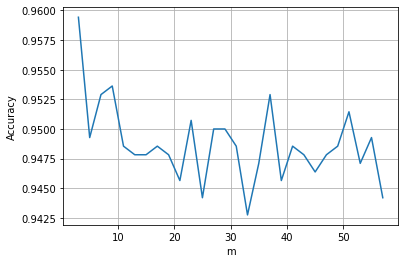

In [12]:
ms=[]
acs=[]

for i in range(3,58,2):
    ms.append(i)

for i in ms:
    rf=RandomForestClassifier(criterion='entropy',max_features=i)
    rf.fit(train[:,:-1],train[:,-1])
    acs.append(rf.score(test[:,:-1],test[:,-1]))

plt.plot(ms,acs)
plt.ylabel('Accuracy')
plt.xlabel('m')
plt.grid()   

### *We can see that the accuracies seem to touch peaks when values of m are close to sqrt(N)/2,sqrt(N),2sqrt(N), where N is total features  (which is 57 here). These are the values which Breiman suggested. Also, when m<<N, accuracies seem to be better, than when m is comparable to N.*

OOB for m= 3 : 0.09593294008072027
OOB for m= 5 : 0.06799130704750078
OOB for m= 7 : 0.0611611300838249
OOB for m= 9 : 0.058366966780502946
OOB for m= 11 : 0.06364483079788885
OOB for m= 13 : 0.06333436820863086
OOB for m= 15 : 0.05898789195901894


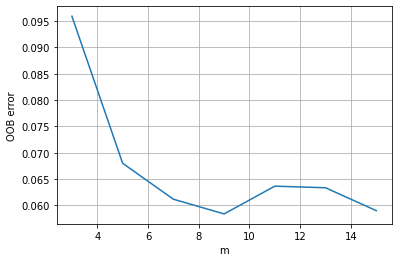

In [24]:
oobs=[]
ms=[]

for i in range(1,16,2):
    ms.append(i)

for i in range(len(ms)):
    oobs.append(random_forest(100,i,train,test,1))
    if(ms[i]>1):
        print("OOB for m=",ms[i],":",oobs[i])

plt.plot(ms[1:],oobs[1:])
plt.ylabel('OOB error')
plt.xlabel('m')
plt.grid()   

### *OOB error seems to decrease as m increases, and it ends up being around 0.06, in the range of m chosen.*